# Vulnerability hatstall

I am proud to anounce that for first time I have got an idea. At the beggining my first idea was to use a supervised ML model but after exploring many times the data I finally decided to use a not supervised model.

In [1]:
import pandas as pd
import seaborn as sns
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

## Functions to use in our notebook

Firstable we are going to define all the functions we are going to use in our script. Those function are not new, they have been created in others notebooks that we use as a draft.

In [2]:
try:
    nlp = spacy.load("en_core_web_lg")
    print("Module loaded properly")
except:
    print("Please install spacy version 2.1 or later")

def parametrize_stop_words(stopwords = spacy.lang.en.STOP_WORDS):
    """Function to reasign stopwords, we are going to need some of them """
    try:
        stopwords.remove('no')
        stopwords.remove('not')# We need the word "NO" for vulns that don't have solution
        stopwords.add('script_tag')
        stopwords.add('script_xref')
        stopwords.remove('of')
    except:
        pass
    return stopwords

def clean_text(text):
    """This special function is for the text field in our dataset. I created to clean the rubbish
    we normally have in our data"""
    text = re.sub(r'(script_oid|SCRIPT\_OID).*?\".*?\.(?P<oid>\d+)\"', '', text)
    text = re.sub(r'script\_family\(\"(?P<script_family>.*?)\"\)', '', text)
    text = re.sub(r'script_copyright.*', '', text)
    text = re.sub(r'script_dependencies.*', '', text)
    text = re.sub(r'script_mandatory_keys.*', '', text)
    text = re.sub(r'.*?cvss\_base\_vector.*', '', text)
    text = re.sub(r'script_version.*', '', text)
    text = re.sub(r'.*?last_modification.*', '', text)
    text = re.sub(r'.*?creation_date.*', '', text)
    text = re.sub(r';', '', text)
    text = re.sub(r'\"', '', text)
    text = re.sub(r'value\:', '', text)
    text = re.sub(r'name\:', '', text)
    text = re.sub(r'\(|\)', ' ', text)
    text = re.sub(r'if.*?(.*?description.*?)', '', text)
    text = re.sub(r'.*?script_xref.*', '', text)
    text = re.sub(r',', '', text)
    return text

def custom_tokenizer(nlp,regex):
    """I created this function to tokenize "CVEs" properly"""
    from spacy.tokenizer import Tokenizer
    prefix_re = re.compile(regex)
    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search)

def remove_stopped_words(text):
    """Function that remove all the stop words and clean new lines and spaces"""
    #print(text)
    nlpobject = nlp(text)
    text_without_stopped_words = [tok.text for tok in nlpobject if (tok.text not in stopwords and tok.pos_ != "PUNCT" and tok.pos_ != "SYM")]
    final_tokenized_words = map(str.rstrip, text_without_stopped_words)
    final_tokenized_words = filter(None, list(final_tokenized_words))
    final_tokenized_words = list(final_tokenized_words)
    return final_tokenized_words

def nlpparser(objectlist):
    """Take the new tokenized list and parse into a spacy document"""
    doc = nlp.tokenizer.tokens_from_list(objectlist)
    nlp.tagger(doc)
    nlp.parser(doc)
    return doc

def look_for_match(terminology_list,match_tag,document):
    from spacy.matcher import PhraseMatcher
    """Function to macth expressions with document"""
    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
    #print(terminology_list,document)
    # Only run nlp.make_doc to speed things up
    patterns = [nlp.make_doc(text) for text in terminology_list]
    matcher.add(match_tag, None, *patterns)
    #doc = nlp(document)
    doc = document
    matches = matcher(doc)
    #for match_id, start, end in matches:
    #    span = doc[start:end]
    #    print(span.text)
    #print(len(matches) != 0)
    return len(matches) != 0

def fill_solution(vec):
    solution_type = vec[11]
    solution_from_plugin = vec[10]
    #print(solution_type, solution_from_plugin)
    if solution_from_plugin is None:
        if solution_type == "Mitigation":
            solution = "Configuration changes"
        elif solution_type == "VendorFix":
            solution = "Please Install the Updated Packages."
        elif solution_type == "Workaround":
            solution = solution_type
    else:
        solution = solution_from_plugin
    return solution

def plot_samples(x, modelfitted, label="Imbalanced openvas data"):
    New_X = x.todense()
    clusters = modelfitted.labels_.tolist()
    pca = PCA(n_components= 2).fit(New_X)
    data2D = pca.transform(New_X)
    sns.scatterplot(data2D[:,0], data2D[:,1], hue=clusters);
    plt.title(label);
    
def look_for_solution(vec):
    """Function to categorize our solutions"""
    SolutionPatch = "Update or patch installation"
    EOL = "End of life Platform"
    Info = "Informational"
    Workaround = "Workaround"
    NoPatch = "No solution or patch available"
    PolicyCompliance = "Policy compliance"
    UselessService = "Unsafe or useless service"
    ConfigurationChanges = "Configuration changes"
    SSLTLS = "SSL/TLS hardening"
    #####OPENVAS ONLY###############
    ToClassify = "To classify"
    GSHB = "GSHB Family"
    NMAP = "NMAP Family"
    cvss_row = vec[2]
    document_row = vec[13]
    solution = ToClassify
    if look_for_match(["vendorfix","upgrade", "update", "patch", "hotfix", "apply", "updates"], "PatchSolution", document_row):
        solution = SolutionPatch
    if look_for_match(["end of life", "eol"],"EndOfLife",document_row):
        solution = EOL
    if look_for_match(["default credentials", "useless services" , "mitigation", "default accounts", "reconfigure", "change", "remove", "comment", "set"], "ConfigurationChanges", document_row):
        solution = ConfigurationChanges
    if look_for_match(["willnotfix", "will not fix", "unfixed", "noneavailable"],"NoSolution",document_row):
        solution = NoPatch
    if look_for_match(["useless services", "disable service"], "UselessServices", document_row):
        solution = UselessService
    if look_for_match(["workaround"], "Workaround", document_row):
        solution = Workaround
    if cvss_row == 0.0:
        solution = Info
    return solution

Module loaded properly


## Loading data
We load the stopwords and our dataset

In [3]:
stopwords = parametrize_stop_words()
openvas_df = pd.read_json('OpenvasLookup.json')

In [5]:
openvas_df[openvas_df['oid'] == 891477]

creation_date                                                cve  \
5651  2018-08-26 00:00:00  [CVE-2018-10887, CVE-2018-10888, CVE-2018-1550...   

      cvss                 cvss_vector           filename  \
5651   5.8  AV:N/AC:M/Au:N/C:P/I:N/A:P  deb_dla_1477.nasl   

     last_modification_date     oid  \
5651    2019-03-18 15:24:29  891477   

                                            plugin_name  script_category  \
5651  Debian LTS Advisory ([SECURITY] [DLA 1477-1] l...  ACT_GATHER_INFO   

                     script_family  \
5651  Debian Local Security Checks   

                                   solution_from_plugin solution_type  \
5651  For Debian 8 'Jessie', these problems have bee...     VendorFix   

                                                   text  
5651  script_oid("1.3.6.1.4.1.25623.1.0.891477");\n ...

In [7]:
openvas_df.sample(100)

creation_date                                                cve  \
10080  2014-07-21 14:27:57                                                 []   
5950   2018-11-18 00:00:00                                   [CVE-2018-17478]   
3585   2018-03-21 10:15:02                                    [CVE-2018-8722]   
35034  2010-11-05 13:21:25                                                 []   
25836  2016-02-21 06:21:43  [CVE-2015-7974, CVE-2015-8138, CVE-2015-7977, ...   
13298  2012-08-30 10:05:00                                    [CVE-2011-1103]   
38834  2013-08-01 18:34:58                                    [CVE-2013-2126]   
33556  2019-02-12 00:00:00  [CVE-2018-20147, CVE-2018-20148, CVE-2018-2014...   
19108  2015-11-12 05:33:43                                    [CVE-2015-1335]   
1364   2017-06-13 09:55:00                                                 []   
27410  2016-07-13 13:02:15                                                 []   
3356   2018-04-19 10:38:34  [CVE-2018-2761, CVE-2018-2771, CVE-2018-2781, ...   
1208   2008-10-24 23:33:44                                                 []   
9722   2014-01-13 11:27:39                                    [CVE-2013-6836]   
51670  2011-09-21 05:47:11  [CVE-2011-2130, CVE-2011-2134, CVE-2011-2135, ...   
19522  2015-06-11 06:31:20  [CVE-2015-2150, CVE-2015-2830, CVE-2015-3331, ...   
48241  2011-01-11 16:07:49                                    [CVE-2010-4523]   
3823   2018-11-02 13:55:59                                    [CVE-2018-4013]   
545    2018-02-02 11:32:17                                                 []   
14181  2012-07-30 17:14:17  [CVE-2011-0084, CVE-2011-2378, CVE-2011-2981, ...   
24475  2015-10-06 14:05:12                                    [CVE-2012-2673]   
5678   2018-01-24 00:00:00                                    [CVE-2018-5345]   
34195  2019-05-07 02:24:41                                                 []   
8369   2018-04-11 08:58:36                     [CVE-2018-1027, CVE-2018-1029]   
49102  2011-02-01 16:46:08                                    [CVE-2010-4700]   
19425  2015-11-11 08:59:53                                    [CVE-2015-6112]   
25172  2015-01-08 05:56:10                                    [CVE-2014-9220]   
4664   2018-11-26 15:08:42  [CVE-2018-0734, CVE-2018-5407, CVE-2018-0734, ...   
13904  2012-02-13 01:48:16                     [CVE-2011-4634, CVE-2011-4634]   
44436  2017-02-20 11:39:00      [CVE-2017-2586, CVE-2017-2587, CVE-2017-5849]   
...                    ...                                                ...   
47494  2005-11-03 14:08:04                                    [CVE-1999-0021]   
25466  2016-10-12 12:07:00                                    [CVE-2016-3209]   
46433  2017-11-23 08:05:54  [CVE-2017-13077, CVE-2017-13078, CVE-2017-1307...   
6737   2018-01-31 07:58:20               [CVE-2018-1000005, CVE-2018-1000007]   
21882  2015-10-08 14:44:45  [CVE-2009-3612, CVE-2009-3620, CVE-2009-3621, ...   
31245  2016-03-11 07:09:15  [CVE-2016-1982, CVE-2016-1983, CVE-2016-1982, ...   
4516   2018-12-22 04:00:40  [CVE-2018-19044, CVE-2018-19045, CVE-2018-1904...   
38619  2013-03-15 09:48:54  [CVE-2013-0305, CVE-2013-0306, CVE-2012-3442, ...   
44839  2017-06-12 12:54:29  [CVE-2017-8439, CVE-2017-8439, CVE-2017-8439, ...   
28529  2016-12-01 05:39:07  [CVE-2016-5290, CVE-2016-5291, CVE-2016-5296, ...   
49353  2011-08-03 04:36:20  [CVE-2011-1752, CVE-2011-1783, CVE-2011-1921, ...   
45086  2017-08-10 07:29:53  [CVE-2017-3308, CVE-2017-3309, CVE-2017-3453, ...   
35010  2019-03-17 11:11:44  [CVE-2019-5418, CVE-2019-5419, CVE-2019-5418, ...   
40450  2013-10-29 11:24:22                                    [CVE-2013-4450]   
37751  2013-04-05 13:51:38  [CVE-2013-1899, CVE-2013-1900, CVE-2013-1901, ...   
938    2014-06-11 14:04:01                                                 []   
24913  2015-04-15 11:36:46                     [CVE-2015-1641, CVE-2015-1639]   
31808  2009-11-04 07:03:36                  

## Cleaning process
Our text is good enough but we need to clean some stuff, that's why we created the "clean_text" function to remove a lot of garbage that is not going to be usefull for our matching categorizing. In my computer every of these steps is going to spend around five minutes, so be patient :).

We remove informational plugins because we don't need it and it might cause trouble to our model

In [5]:
openvas_vulns_df = openvas_df.query('cvss != 0.0')

In [6]:
openvas_df.query('oid == 105939')

creation_date              cve  cvss                 cvss_vector  \
13393  2015-01-21 09:55:57  [CVE-2014-8272]   5.0  AV:N/AC:L/Au:N/C:N/I:P/A:N   

                             filename last_modification_date     oid  \
13393  gb_ipmiv15_sessionid_vuln.nasl    2018-09-07 16:48:41  105939   

                                   plugin_name script_category script_family  \
13393  Dell iDRAC Weak SessionID Vulnerability      ACT_ATTACK       General   

                                    solution_from_plugin solution_type  \
13393  Updates from Dell are available which will dis...     VendorFix   

                                                    text  
13393  if (description)\n\n  script_oid("1.3.6.1.4.1....

In [7]:
openvas_df['oid'].count()

50236

In [8]:
openvas_vulns_df['oid'].count()

46622

In [9]:
openvas_vulns_df.sample(1)

creation_date                             cve  cvss  \
33026  2010-09-02 16:10:00  [CVE-2010-2861, CVE-2010-2861]   7.5   

                      cvss_vector                  filename  \
33026  AV:N/AC:L/Au:N/C:P/I:P/A:P  gb_coldfusion_42342.nasl   

      last_modification_date     oid  \
33026    2019-03-19 14:40:32  100772   

                                             plugin_name script_category  \
33026  Adobe ColdFusion Directory Traversal Vulnerabi...      ACT_ATTACK   

                script_family  \
33026  Web application abuses   

                                    solution_from_plugin solution_type  \
33026  Updates are available. Please see the referenc...     VendorFix   

                                                    text  
33026  if (description)\n\n  script_oid("1.3.6.1.4.1....

In [10]:
openvas_vulns_df[openvas_vulns_df['solution_from_plugin'].apply(lambda x: x is None)]['oid'].count()

250

We can see that there are three type of solution_type. So I decided to map those solutions like that: 

- if solution_type is "Mitigation" then I will assume that "solution" is "Configuration changes".
- if solution_type is "VendorFix" then I will assume that "solution" is "Please Install the Updated Packages."
- if solution_type is "Workaround" then I will assume that "solution" is "Workaround". 

In [11]:
vulns_without_sol_type = openvas_vulns_df[openvas_vulns_df['solution_from_plugin'].apply(
    lambda x: x is None)][['oid','solution_type']].groupby('solution_type').count().reset_index()
vulns_without_sol_type

solution_type  oid
0    Mitigation  191
1     VendorFix   57
2    Workaround    2

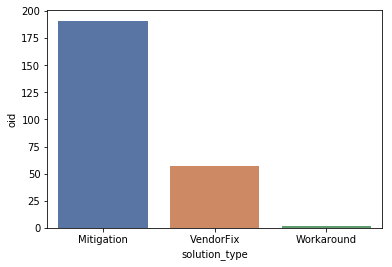

In [12]:
sns.barplot(x= vulns_without_sol_type['solution_type'], 
            y=vulns_without_sol_type['oid'], 
            palette="deep");

In [13]:
openvas_by_plugin_name = openvas_vulns_df.groupby('plugin_name')

In [14]:
openvas_vulns_df[openvas_vulns_df["plugin_name"].str.contains("debian")]

creation_date                                                cve  \
36200  2018-01-29 00:00:00                                                 []   
41238  2011-03-07 16:04:02  [CVE-2010-3429, CVE-2010-4704, CVE-2010-4705, ...   

       cvss                 cvss_vector          filename  \
36200   5.0  AV:N/AC:L/Au:N/C:P/I:N/A:N  deb_dla_979.nasl   
41238   9.3  AV:N/AC:M/Au:N/C:C/I:C/A:C   deb_2165_1.nasl   

      last_modification_date     oid  \
36200    2019-03-18 15:53:48  890979   
41238    2019-03-18 15:39:45   68976   

                                             plugin_name  script_category  \
36200  Debian LTS Advisory ([SECURITY] [DLA 979-1] de...  ACT_GATHER_INFO   
41238  Debian Security Advisory DSA 2165-1 (ffmpeg-de...  ACT_GATHER_INFO   

                      script_family  \
36200  Debian Local Security Checks   
41238  Debian Local Security Checks   

                                    solution_from_plugin solution_type  \
36200  For Debian 7 'Wheezy', these problems have bee...     VendorFix   
41238  We recommend that you upgrade your ffmpeg-debi...     VendorFix   

                                                    text  
36200  script_oid("1.3.6.1.4.1.25623.1.0.890979");\n ...  
41238  script_oid("1.3.6.1.4.1.25623.1.0.68976");\n  ...

In [15]:
openvas_vulns_df[openvas_vulns_df['plugin_name'].apply(lambda x: x is None)]['oid'].count()

0

## Applying model(s)

As we have the dataframe loaded in RAM, we are going to keep working with it. We are going to use a non-supervised ML model to group similar solutions from our dataset. So, we must first declare our vectorizer, in this case we set stop_words to None because we cleaned the solutions and removed the stop words before. 

In [16]:
vectorizer = TfidfVectorizer(stop_words = None)

In [17]:
tfs = vectorizer.fit_transform(openvas_vulns_df['plugin_name'].values)

I am going to use a random kmeans algorihtm, I just want to see a big problem we have with our samples.

In [18]:
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tfs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

What happens if we want to plot?

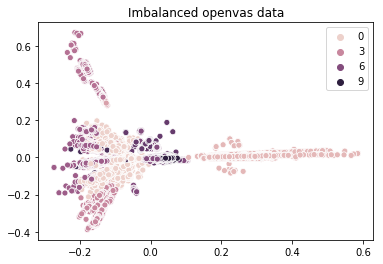

In [19]:
#New_X = tfs.todense()
#clusters = model.labels_.tolist()
#pca = PCA(n_components=true_k).fit(New_X)
#data2D = pca.transform(New_X)
#sns.scatterplot(data2D[:,0], data2D[:,1], hue=clusters);
#plt.title('Imbalanced openvas data');
plot_samples(tfs,model)

We have imbalanced sample of data because maybe 90% or more of the plugin can be solved by update or patch. If we try to predict any vulnerability solution the model is going to put all in the same group.

In [20]:
Y = vectorizer.transform(["Adobe"])
prediction = model.predict(Y)
print(prediction)

[0]


I realised that I would have to deal with my samples at the beggining but I also know that plots look much more beautiful to show that :). Another way to see the oversampling without using any model is the way I show below: 

In [21]:
openvas_solution_type = openvas_vulns_df[['solution_type','oid']].groupby(
    'solution_type').count().reset_index()

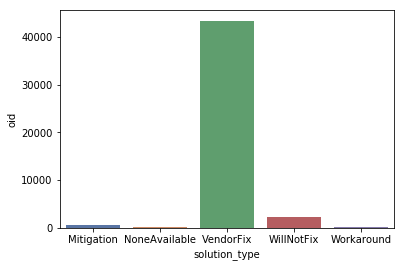

In [22]:
sns.barplot(x= openvas_solution_type['solution_type'], 
            y=openvas_solution_type['oid'], 
            palette="deep");

In this case we have three choices: 

1. Removing samples from the majority class (Undersampling)
2. Adding more examples from the minority class (Oversampling)
3. Combining both.


#### Manually undersampling

The first thing I am going to try it's to manually undersample my dataset. I just do it for trying. 

In [23]:
#from sklearn.model_selection import GridSearchCV
#new_model = GridSearchCV(KMeans(),
#                     param_grid={"n_clusters" : np.arange(10,100)},
#                     cv=10)

In [24]:
#tfs = vectorizer.fit_transform(openvas_vulns_df['plugin_name'].values)
#new_model.fit(tfs)

In [25]:
#new_model.best_estimator_
# Best estimator from gridsearch that was running for two days
#KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    #n_clusters=94, n_init=10, n_jobs=None, precompute_distances='auto',
    #random_state=None, tol=0.0001, verbose=0)

In [26]:
new_model = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=94, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
new_model.fit(tfs)

print("Top terms per cluster:")
order_centroids = new_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Y = vectorizer.transform(["adobe"])
prediction = new_model.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:
 security
 dsa
 debian
 advisory
 update
 browser
 chromium
 icedove
 iceweasel
 php5
Cluster 1:
 rhsa
 redhat
 2015
 01
 for
 update
 kernel
 kvm
 firefox
 qemu
Cluster 2:
 mediawiki
 fedora
 for
 update
 vulnerabilities
 multiple
 2014
 windows
 2013
 linux
Cluster 3:
 fedora
 2017
 for
 update
 globus
 mingw
 8f27031c8f
 3a568adb31
 xen
 python
Cluster 4:
 firefox
 ubuntu
 usn
 for
 update
 3918
 3477
 3761
 1681
 mdva
Cluster 5:
 code
 execution
 remote
 vulnerability
 windows
 arbitrary
 vulnerabilities
 php
 allow
 could
Cluster 6:
 open
 xchange
 appsuite
 ox
 redirect
 vulnerability
 multiple
 redirection
 vulnerabilities
 scripting
Cluster 7:
 opensuse
 suse
 su
 2018
 kernel
 for
 update
 the
 linux
 imagemagick
Cluster 8:
 clamav
 fedora
 for
 update
 usn
 ubuntu
 suse
 2018
 su
 opensuse
Cluster 9:
 moin
 fedora
 for
 update
 ubuntu
 usn
 2016
 2013
 3794
 3137
[28]


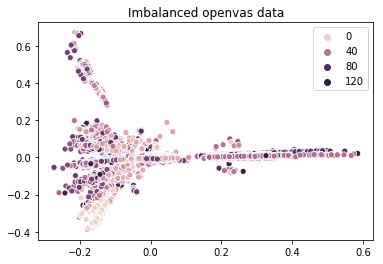

In [27]:
plot_samples(tfs,new_model)

In [28]:
Y = vectorizer.transform(["'No known solution was made available for at least one year since the disclosure of this vulnerability. Likely none will be provided anymore. General solution options are to upgrade to a newer release, disable respective features, remove the product or replace the product by another one.'"])
prediction = model.predict(Y)
print(prediction)

[0]


In [29]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print
    
Y = vectorizer.transform(["Update to version 100 respectively."])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["'No known solution was made available for at least one year since the disclosure of this vulnerability. Likely none will be provided anymore. General solution options are to upgrade to a newer release, disable respective features, remove the product or replace the product by another one.'"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Upgrade IBM WebSphere Application Server WAS version 7.0.0.27 8.0.0.5 8.5.0.1 later"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Adobe"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Microsoft"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["microsoft"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Debian Local Security Checks"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Debian Local Security Checks", "debian"])
prediction = model.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:
 vulnerability
 windows
 of
 service
 denial
 security
 disclosure
 updates
 information
 site
Cluster 1:
 fedora
 for
 update
 2013
 2016
 2017
 2014
 2018
 2015
 2012
Cluster 2:
 freebsd
 ports
 mageia
 mgasa
 check
 local
 linux
 2015
 2016
 chromium
Cluster 3:
 security
 advisory
 debian
 dsa
 dla
 update
 glsa
 gentoo
 lts
 several
Cluster 4:
 check
 local
 elsa
 linux
 oracle
 alas
 amazon
 2014
 2015
 2013
Cluster 5:
 multiple
 vulnerabilities
 windows
 01
 mac
 os
 microsoft
 adobe
 mozilla
 linux
Cluster 6:
 suse
 su
 opensuse
 for
 update
 2018
 kernel
 chromium
 mozillafirefox
 2016
Cluster 7:
 ubuntu
 usn
 for
 update
 rhsa
 redhat
 01
 linux
 lts
 firefox
Cluster 8:
 execution
 code
 remote
 microsoft
 vulnerability
 office
 vulnerabilities
 windows
 arbitrary
 command
Cluster 9:
 centos
 cesa
 for
 centos5
 update
 centos6
 i386
 centos7
 2011
 centos4
[0]
[0]
[0]
[0]
[8]
[8]
[3]
[3 3]


In [30]:
def put_in_iterator(input_string):
    my_list = [None]
    return tuple(input_string for s in my_list)

In [31]:
put_in_iterator('Hola mundo')

('Hola mundo',)

In [32]:
openvas_vulns_df['cluster_label'] = openvas_vulns_df['plugin_name'].apply(put_in_iterator)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
openvas_vulns_df['plugin_name'].count()

46622

In [34]:
openvas_vulns_df[openvas_vulns_df['solution_from_plugin'].apply(lambda x: x is None)]['oid'].count()

250

In [35]:
openvas_vulns_df.tail()

creation_date                                                cve  \
50228  2012-06-21 11:43:12  [CVE-2006-7243, CVE-2010-2094, CVE-2010-2950, ...   
50230  2012-06-21 11:43:12  [CVE-2006-1015, CVE-2006-1549, CVE-2006-2660, ...   
50231  2012-06-21 11:43:12  [CVE-2006-6383, CVE-2007-0905, CVE-2007-0906, ...   
50234  2012-06-14 13:15:22  [CVE-2011-4566, CVE-2011-4885, CVE-2012-0057, ...   
50235  2009-08-10 08:41:48                                                 []   

       cvss                 cvss_vector                    filename  \
50228   6.8  AV:N/AC:M/Au:N/C:P/I:P/A:P       nopsec_php_5_3_4.nasl   
50230  10.0  AV:N/AC:L/Au:N/C:C/I:C/A:C       nopsec_php_5_2_0.nasl   
50231  10.0  AV:N/AC:L/Au:N/C:C/I:C/A:C       nopsec_php_5_2_1.nasl   
50234   6.4  AV:N/AC:L/Au:N/C:P/I:N/A:P       nopsec_php_5_3_9.nasl   
50235   7.8  AV:N/AC:L/Au:N/C:N/I:N/A:C  remote-pwcrack-pd-ssh.nasl   

      last_modification_date     oid  \
50228    2018-07-09 09:50:03  110181   
50230    2018-07-09 09:50:03  110173   
50231    2018-07-09 09:50:03  110175   
50234    2018-07-09 09:50:03  110012   
50235    2019-02-11 11:22:27   80106   

                                        plugin_name  script_category  \
50228  PHP Version < 5.3.4 Multiple Vulnerabilities  ACT_GATHER_INFO   
50230  PHP Version < 5.2.0 Multiple Vulnerabilities  ACT_GATHER_INFO   
50231  PHP Version < 5.2.1 Multiple Vulnerabilities  ACT_GATHER_INFO   
50234  PHP Version < 5.3.9 Multiple Vulnerabilities  ACT_GATHER_INFO   
50235                         phrasen|drescher: SSH       ACT_ATTACK   

                script_family  \
50228  Web application abuses   
50230  Web application abuses   
50231  Web application abuses   
50234  Web application abuses   
50235     Brute force attacks   

                                    solution_from_plugin solution_type  \
50228              Update PHP to version 5.3.4 or later.     VendorFix   
50230              Update PHP to version 5.2.0 or later.     VendorFix   
50231              Update PHP to version 5.2.1 or later.     VendorFix   
50234            Upgrade PHP to 5.3.9 or versions after.     VendorFix   
50235  Set a secure password for the mentioned accoun...    Mitigation   

                                                    text  \
50228  CPE = "cpe:/a:php:php";\n\n\n\n  script_oid("1...   
50230  CPE = "cpe:/a:php:php";\n\n\n\n  script_oid("1...   
50231  CPE = "cpe:/a:php:php";\n\n\n\n  script_oid("1...   
50234  CPE = "cpe:/a:php:php";\n\n\n\n  script_oid("1...   
50235  script_oid("1.3.6.1.4.1.25623.1.0.80106");\n  ...   

                                         cluster_label  
50228  (PHP Version < 5.3.4 Multiple Vulnerabilities,)  
50230  (PHP Version < 5.2.0 Multiple Vulnerabilities,)  
50231  (PHP Version < 5.2.1 Multiple Vulnerabilities,)  
50234  (PHP Version < 5.3.9 Multiple Vulnerabilities,)  
50235                         (phrasen|drescher: SSH,)

In [36]:
openvas_vulns_df['cluster_label'] = openvas_vulns_df.cluster_label.apply(vectorizer.transform)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
openvas_vulns_df['cluster_label'] = openvas_vulns_df.cluster_label.apply(new_model.predict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
openvas_vulns_df.head()

creation_date                                            cve  cvss  \
191  2005-11-03 14:08:04                 [CVE-2005-1062, CVE-2005-1063]   7.5   
296  2015-01-26 11:22:03                                             []   7.5   
494  2009-03-23 19:32:33  [CVE-1999-0512, CVE-2002-1278, CVE-2003-0285]  10.0   
729  2005-11-03 14:08:04                                [CVE-2004-2713]   1.9   
766  2005-11-03 14:08:04                                             []   3.3   

                    cvss_vector                                filename  \
191  AV:N/AC:L/Au:N/C:P/I:P/A:P          kerio_firewall_admin_port.nasl   
296  AV:N/AC:L/Au:N/C:P/I:P/A:P  gb_viewheadline.php_sql_inj_01_15.nasl   
494  AV:N/AC:L/Au:N/C:C/I:C/A:C                         smtp_relay.nasl   
729  AV:L/AC:M/Au:N/C:N/I:N/A:P               zone_alarm_local_dos.nasl   
766  AV:L/AC:M/Au:N/C:N/I:P/A:P                    mldonkey_telnet.nasl   

    last_modification_date     oid  \
191    2019-02-08 14:21:52   18183   
296    2018-09-18 12:04:42  105186   
494    2019-02-05 13:39:51  100073   
729    2018-06-14 16:39:20   14726   
766    2018-08-10 16:32:11   11124   

                                           plugin_name  script_category  \
191              Kerio Personal Firewall Admin Service  ACT_GATHER_INFO   
296  viewheadline.php WP-Plugin SQL Injection Vulne...       ACT_ATTACK   
494                                      Mail relaying  ACT_GATHER_INFO   
729                            ZoneAlarm Pro local DoS  ACT_GATHER_INFO   
766                                    mldonkey telnet  ACT_GATHER_INFO   

                 script_family  \
191          Service detection   
296     Web application abuses   
494              SMTP problems   
729                  Firewalls   
766  Peer-To-Peer File Sharing   

                                  solution_from_plugin solution_type  \
191  If this service is not needed, disable it or f...    Mitigation   
296  No known solution was made available for at le...    WillNotFix   
494  Improve the configuration of your SMTP server ...    Mitigation   
729     Upgrade to the latest version of this software     VendorFix   
766                                         Disable it    Mitigation   

                                                  text cluster_label  
191  script_oid("1.3.6.1.4.1.25623.1.0.18183");\n  ...          [16]  
296  CPE = "cpe:/a:wordpress:wordpress";\n\n\n\n  s...          [42]  
494  script_oid("1.3.6.1.4.1.25623.1.0.100073");\n ...          [16]  
729  script_oid("1.3.6.1.4.1.25623.1.0.14726");\n  ...          [16]  
766  script_oid("1.3.6.1.4.1.25623.1.0.11124");\n  ...          [16]

In [39]:
openvas_vulns_df[openvas_vulns_df["plugin_name"].str.contains("Jenkins")].sample(5)

creation_date                                                cve  \
15706  2015-03-02 12:00:00                                                 []   
34620  2019-04-17 08:14:25  [CVE-2019-1003049, CVE-2019-1003050, CVE-2019-...   
26598  2017-11-07 10:05:00               [CVE-2017-1000391, CVE-2017-1000392]   
49450  2016-08-04 13:00:09                                    [CVE-2011-4344]   
30313  2017-01-30 13:00:00                                    [CVE-2016-9299]   

       cvss                 cvss_vector  \
15706  10.0  AV:N/AC:L/Au:N/C:C/I:C/A:C   
34620   6.8  AV:N/AC:M/Au:N/C:P/I:P/A:P   
26598   4.9  AV:N/AC:M/Au:S/C:N/I:P/A:P   
49450   2.6  AV:N/AC:H/Au:N/C:N/I:P/A:N   
30313   7.5  AV:N/AC:L/Au:N/C:P/I:P/A:P   

                                                filename  \
15706                     sw_jenkins_groovy_console.nasl   
34620                           gb_jenkins_1327_win.nasl   
26598                       gb_jenkins_20171108_lin.nasl   
49450  gb_cloudbees_jenkins_winstone_xss_vuln_aug16_l...   
30313                gb_cloudbees_jenkins_94281_lin.nasl   

      last_modification_date     oid  \
15706    2018-12-11 15:32:20  111002   
34620    2019-04-17 09:17:28  142270   
26598    2018-12-11 15:32:20  112130   
49450    2018-12-11 15:32:20  808277   
30313    2018-12-11 15:32:20  108063   

                                             plugin_name  script_category  \
15706               Jenkins CI Groovy Console accessible       ACT_ATTACK   
34620  Jenkins < 2.164.2 LTS and < 2.172 Multiple Vul...  ACT_GATHER_INFO   
26598    Jenkins Multiple Vulnerabilities Nov 17 (Linux)  ACT_GATHER_INFO   
49450  Jenkins Winstone Servlet Cross Site Scripting ...  ACT_GATHER_INFO   
30313  CloudBees Jenkins Java Deserialization Remote ...  ACT_GATHER_INFO   

                script_family  \
15706  Web application abuses   
34620  Web application abuses   
26598  Web application abuses   
49450  Web application abuses   
30313  Web application abuses   

                                    solution_from_plugin solution_type  \
15706  Protect the access to the Groovy Console by\n ...    Mitigation   
34620  Update to version 2.164.2 (LTS) and 2.172 (wee...     VendorFix   
26598  Upgrade to Jenkins weekly to 2.89 or later / J...     VendorFix   
49450  Upgrade to CloudBees Jenkins LTS 1.409.3 or\n ...     VendorFix   
30313  Upgrade to CloudBees Jenkins to 2.32 or later ...     VendorFix   

                                                    text cluster_label  
15706  CPE = "cpe:/a:jenkins:jenkins";\n\n\n\n  scrip...          [16]  
34620  CPE = 'cpe:/a:jenkins:jenkins';\n\n\n\n  scrip...          [45]  
26598  CPE = "cpe:/a:jenkins:jenkins";\n\n\n\n  scrip...          [71]  
49450  CPE = "cpe:/a:jenkins:jenkins";\n\n\n\n  scrip...          [66]  
30313  CPE = "cpe:/a:jenkins:jenkins";\n\n\n\n  scrip...           [5]

In [40]:
openvas_vulns_df.cluster_label = openvas_vulns_df.cluster_label.apply(lambda x: x[0])

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [41]:
openvas_final_groupped = openvas_vulns_df[['cluster_label','plugin_name','oid']].groupby(['cluster_label', 'plugin_name','oid'])

In [42]:
openvas_final_groupped.count().reset_index().sample(20)

cluster_label                                        plugin_name  \
9612              18               Ubuntu Update for dovecot USN-3928-1   
43019             88         Fedora Update for lldpad FEDORA-2013-12178   
12166             18           Ubuntu Update for thunderbird USN-3897-1   
14814             28  Adobe Acrobat and Reader PDF Handling Code Exe...   
25694             49            Fedora Update for wicd FEDORA-2012-5909   
29532             62     RedHat Update for vixie-cron RHSA-2012:0304-03   
30154             65  Gallery Unspecified Security Bypass Vulnerability   
39233             78             Fedora Update for xen FEDORA-2015-3944   
36174             73  Microsoft .NET Framework Information Disclosur...   
5634              11                   FreeBSD Ports: linux-flashplugin   
36593             73  openssh-server Forced Command Handling Informa...   
12566             21  Slackware Advisory SSA:2003-141-06 quotacheck ...   
15026             30      Fedora Update for anki FEDORA-2018-58b0c6a60e   
22936             44  Apple Mac OS X Multiple Vulnerabilities -08 Sep14   
5389              10  Mozilla Firefox Security Bypass Vulnerability ...   
26950             54    Fedora Update for mingw-gnutls FEDORA-2014-2583   
23921             45  WordPress Multiple Vulnerabilities - May17 (Wi...   
25917             51  Google Chrome Multiple Vulnerabilities - 01 Ju...   
10945             18     Ubuntu Update for linux-lts-quantal USN-1828-1   
24867             49  Fedora Update for calligra-l10n FEDORA-2012-11566   

          oid  
9612   843950  
43019  866537  
12166  843914  
14814  902128  
25694  864177  
29532  870550  
30154  800312  
39233  869121  
36174  813760  
5634    69361  
36593  103503  
12566   53898  
15026  874389  
22936  804854  
5389   805746  
26950  867534  
23921  811045  
25917  804618  
10945  841425  
24867  864634

In [43]:
openvas_results = pd.read_csv('ResultsFromScan.csv')

As we did with plugins, we are going to remove all the informationals because we do not need it for our problem.

In [44]:
openvas_results_df = openvas_results.query('cvss != 0.0')

In [45]:
openvas_results_df['oid'].count()

463

In [46]:
openvas_results['oid'].count()

531

In [47]:
openvas_results_df['cluster_label'] = openvas_results_df['signature'].apply(put_in_iterator)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
openvas_results_df['cluster_label'] = openvas_results_df.cluster_label.apply(vectorizer.transform)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
openvas_results_df['cluster_label'] = openvas_results_df.cluster_label.apply(new_model.predict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
openvas_results_df.sample(5)

country                                              cve{}  cvss     oid  \
494     MEX                                                NaN   5.0   10736   
385     MEX        CVE-2013-1332\nCVE-2013-1333\nCVE-2013-1334   7.2  903208   
268     MEX        CVE-2013-0648\nCVE-2013-0643\nCVE-2013-0504  10.0  803323   
375     MEX                                      CVE-2009-4073   5.0  900897   
447     MEX  CVE-2013-3128\nCVE-2013-3200\nCVE-2013-3879\nC...   9.3  903500   

     port protocol                                            results  \
494   135      tcp  Vulnerability Detection Result:  Here is the l...   
385     0      tcp  Affected Software/OS:  Microsoft Windows 8   M...   
268     0      tcp  Vulnerability Detection Result:  Installed ver...   
375     0      tcp  Affected Software/OS:  Microsoft Internet Expl...   
447     0      tcp  Vulnerability Detection Result:  File checked:...   

                                             signature  \
494   DCE/RPC and MSRPC Services Enumeration Reporting   
385  Microsoft Windows Kernel-Mode Drivers Privileg...   
268  Adobe Flash Player Multiple Vulnerabilities -0...   
375  Microsoft Internet Explorer PDF Information Di...   
447  MS Windows Kernel-Mode Drivers Remote Code Exe...   

                              type              IP cluster_label  
494                        Windows  192.168.100.56          [16]  
385  Windows : Microsoft Bulletins  192.168.100.56          [25]  
268                        General  192.168.100.56          [59]  
375                        General  192.168.100.56          [27]  
447  Windows : Microsoft Bulletins  192.168.100.56           [5]

In [51]:
openvas_results_df[openvas_results_df.oid == 809393]

country                                              cve{}  cvss     oid  \
1     MEX  CVE-2016-5556\nCVE-2016-5568\nCVE-2016-5582\nC...   9.3  809393   

   port protocol                                            results  \
1     0      tcp  Vulnerability Detection Result:  Installed ver...   

                                           signature     type              IP  \
1  Oracle Java SE Multiple Unspecified Vulnerabil...  General  192.168.100.56   

  cluster_label  
1          [39]

In [52]:
openvas_results_df[openvas_results_df["signature"].str.contains("Microsoft")].sample(10)

country                                              cve{}  cvss     oid  \
265     MEX                                      CVE-2008-7295   5.8  802140   
71      MEX  CVE-2014-0297\nCVE-2014-0298\nCVE-2014-0299\nC...   9.3  804500   
446     MEX  CVE-2013-3899\nCVE-2013-3902\nCVE-2013-3903\nC...   7.2  903417   
383     MEX        CVE-2012-4781\nCVE-2012-4782\nCVE-2012-4787   9.3  902696   
239     MEX  CVE-2000-1081\nCVE-2000-0202\nCVE-2000-0485\nC...   7.5   11217   
456     MEX  CVE-2010-3141\nCVE-2010-3142\nCVE-2010-3146\nC...   9.3  902254   
431     MEX  CVE-2013-1248\nCVE-2013-1249\nCVE-2013-1250\nC...   4.9  902943   
36      MEX  CVE-2015-1652\nCVE-2015-1657\nCVE-2015-1659\nC...   9.3  805163   
348     MEX                                      CVE-2013-3918   9.3  901225   
10      MEX  CVE-2016-7268\nCVE-2016-7276\nCVE-2016-7298\nC...   9.3  809750   

     port protocol                                            results  \
265     0      tcp  Affected Software/OS:  Microsoft Explorer vers...   
71      0      tcp  Affected Software/OS:  Microsoft Internet Expl...   
446     0      tcp  Affected Software/OS:  Microsoft Windows 8 Win...   
383     0      tcp  Affected Software/OS:  Microsoft Internet Expl...   
239     0      tcp  Vulnerability Detection Result:  Detected mssq...   
456     0      tcp  Vulnerability Detection Result:  Installed ver...   
431     0      tcp  Affected Software/OS:  Microsoft Windows XP x3...   
36      0      tcp  Affected Software/OS:  Microsoft Internet Expl...   
348     0      tcp  Affected Software/OS:  Microsoft Windows 8 Mic...   
10      0      tcp  Vulnerability Detection Result:  File checked:...   

                                             signature  \
265  Microsoft Explorer HTTPS Sessions Multiple Vul...   
71   Microsoft Internet Explorer Multiple Memory Co...   
446  Microsoft Windows Kernel Local Privilege Escal...   
383  Microsoft Internet Explorer Multiple Vulnerabi...   
239                      Microsoft's SQL Version Query   
456  Microsoft Office Products Insecure Library Loa...   
431  Microsoft Windows Kernel-Mode Drivers Privileg...   
36   Microsoft Internet Explorer Multiple Memory Co...   
348  Microsoft Windows ActiveX Control RCE Vulnerab...   
10   Microsoft Office Suite Multiple Vulnerabilitie...   

                              type              IP cluster_label  
265                        General  192.168.100.56          [45]  
71   Windows : Microsoft Bulletins  192.168.100.56          [27]  
446  Windows : Microsoft Bulletins  192.168.100.56          [74]  
383  Windows : Microsoft Bulletins  192.168.100.56          [27]  
239                        Windows  192.168.100.56          [42]  
456                        Windows  192.168.100.56          [16]  
431  Windows : Microsoft Bulletins  192.168.100.56          [25]  
36   Windows : Microsoft Bulletins  192.168.100.56          [27]  
348  Windows : Microsoft Bulletins  192.168.100.56          [16]  
10   Windows : Microsoft Bulletins  192.168.100.56          [45]

In [53]:
openvas_results_df.cluster_label = openvas_results_df.cluster_label.apply(lambda x: x[0])

In [54]:
openvas_results_df[openvas_results_df["signature"].str.contains("Microsoft")].count()

country          236
cve{}            229
cvss             236
oid              236
port             236
protocol         236
results          236
signature        236
type             236
IP               236
cluster_label    236
dtype: int64

In [55]:
openvas_results_groupped = openvas_results_df[openvas_results_df["signature"].str.contains("Microsoft")].groupby('cluster_label').count().reset_index()

In [56]:
#openvas_results_groupped['total'] = openvas_results_groupped.sum(axis=1)
#openvas_results_groupped.append(openvas_results_groupped.sum(numeric_only=True), ignore_index=True)
openvas_results_groupped[['cluster_label','oid']].append(openvas_results_groupped[['oid']].sum(numeric_only=True), ignore_index=True)

cluster_label    oid
0             5.0    1.0
1            16.0   19.0
2            25.0   19.0
3            27.0   49.0
4            42.0    2.0
5            45.0    8.0
6            48.0   79.0
7            57.0   13.0
8            65.0    6.0
9            73.0    9.0
10           74.0   10.0
11           77.0    1.0
12           81.0   10.0
13           86.0    4.0
14           90.0    6.0
15            NaN  236.0

In [58]:
openvas_results_df.merge(openvas_vulns_df, on='oid', how='left').sample(5)

country                                              cve{}  cvss_x  \
21      MEX  CVE-2017-2982\nCVE-2017-2984\nCVE-2017-2985\nC...    10.0   
334     MEX        CVE-2013-1278\nCVE-2013-1279\nCVE-2013-1280     7.2   
58      MEX                       CVE-2016-5287\nCVE-2016-5288    10.0   
338     MEX        CVE-2013-3128\nCVE-2013-3860\nCVE-2013-3861     9.3   
289     MEX  CVE-2011-3547\nCVE-2011-3548\nCVE-2011-3552\nC...    10.0   

        oid  port protocol                                            results  \
21   810551     0      tcp  Vulnerability Detection Result:  Installed ver...   
334  902944     0      tcp  Affected Software/OS:  Microsoft Windows XP x3...   
58   809390     0      tcp  Vulnerability Detection Result:  Installed ver...   
338  903412     0      tcp  Affected Software/OS:  Microsoft .NET Framewor...   
289  802273     0      tcp  Affected Software/OS:  Oracle Java SE versions...   

                                             signature  \
21   Adobe Flash Player Security Updates( apsb17-04...   
334  Microsoft Windows Kernel Privilege Elevation V...   
58   Mozilla Firefox Security Updates( mfsa_2016-87...   
338  Microsoft .NET Framework Remote Code Execution...   
289  Oracle Java SE Multiple Vulnerabilities - Octo...   

                              type              IP  ...  \
21                         General  192.168.100.56  ...   
334  Windows : Microsoft Bulletins  192.168.100.56  ...   
58                         General  192.168.100.56  ...   
338  Windows : Microsoft Bulletins  192.168.100.56  ...   
289                        General  192.168.100.56  ...   

                    cvss_vector  \
21   AV:N/AC:L/Au:N/C:C/I:C/A:C   
334  AV:L/AC:L/Au:N/C:C/I:C/A:C   
58   AV:N/AC:L/Au:N/C:P/I:P/A:P   
338  AV:N/AC:M/Au:N/C:C/I:C/A:C   
289  AV:N/AC:L/Au:N/C:C/I:C/A:C   

                                             filename last_modification_date  \
21           gb_adobe_flash_player_apsb17-04_win.nasl    2018-10-19 09:28:56   
334                              secpod_ms13-017.nasl    2019-05-03 12:31:27   
58   gb_mozilla_firefox_mfsa_2016-87_2016-87_win.nasl    2019-03-12 15:02:42   
338                              secpod_ms13-082.nasl    2019-05-03 12:31:27   
289     gb_oracle_java_se_mult_vuln_oct11_win_01.nasl    2018-10-20 13:59:41   

                                           plugin_name  script_category  \
21   Adobe Flash Player Security Updates( apsb17-04...  ACT_GATHER_INFO   
334  Microsoft Windows Kernel Privilege Elevation V...  ACT_GATHER_INFO   
58   Mozilla Firefox Security Updates( mfsa_2016-87...  ACT_GATHER_INFO   
338  Microsoft .NET Framework Remote Code Execution...  ACT_GATHER_INFO   
289  Oracle Java SE Multiple Vulnerabilities - Octo...  ACT_GATHER_INFO   

                     script_family  \
21                         General   
334  Windows : Microsoft Bulletins   
58                         General   
338  Windows : Microsoft Bulletins   
289                        General   

                                  solution_from_plugin solution_type  \
21   Upgrade to Adobe Flash Player version\n  24.0....     VendorFix   
334  The vendor has released updates. Please see th...     VendorFix   
58   Upgrade to Mozilla Firefox version 49.0.2\n  o...     VendorFix   
338  The vendor has released updates. Please see th...     VendorFix   
289  Upgrade to Oracle Java SE versions 7 Update 1,...     VendorFix   

                                                  text cluster_label_y  
21   CPE = "cpe:/a:adobe:flash_player";\n\n\n\n  sc...              59  
334  script_oid("1.3.6.1.4.1.25623.1.0.902944");\n ...              25  
58   CPE = "cpe:/a:mozilla:firefox";\n\n\n\n  scrip...              10  
338  script_oid("1.3.6.1.4.1.25623.1.0.903412");\n ...              48  
289  script_oid("1.3.6.1.4.1.25623.1.0.802273");\n ...              39  

[5 rows x 24 columns]

This model has some problems because tidf could not vectorize many words, I know that I need to train another model with give me the vector for many words but in the past I did not have anything, now I have something that could solve my problem of vulnerability aggregations, so I am going to save this model in disk.

In [59]:
import pickle
filename = 'kmean_vulns.sav'
pickle.dump(new_model,open(filename, 'wb'))